---

# 🫀 Project: Guardian Ops - ECG Digitization at Scale
**Capstone Project: George B. Moody PhysioNet Challenge Implementation**

---

## 1. Introduction & Executive Summary

### 🎯 Objective
Cardiovascular Diseases (CVDs) are the leading cause of death globally. While modern medicine relies on digital time-series data for AI diagnostics, **billions of historical ECGs** exist only as paper printouts, particularly in the Global South. These physical records are currently inaccessible to modern algorithms.

**The Goal:** Build an automated "Computer Vision to Time-Series" pipeline that extracts raw voltage signals (mV) from 2D ECG images.

### ❓ Problem Statement
Extracting signals from paper ECGs is non-trivial due to:
1.  **Imaging Artifacts:** Scans are often rotated, blurry, or contain shadows (photos taken by phones).
2.  **Grid Interference:** ECG paper has dense grid lines that overlap with the signal trace.
3.  **Layout Variability:** Clinical ECGs arrange the 12 leads (I, II, III, V1-V6) in different spatial grids (3x4, 6x2, etc.).

### 💡 The Solution: "Guardian Ops" MAS
Instead of a monolithic "Black Box" Deep Learning model, I have architected a **Multi-Agent System (MAS)** named "Guardian Ops". This modular approach allows us to handle specific sub-tasks (cleaning, segmentation, signal extraction) independently, making the system explainable and robust.

---

## 2. Dataset Description

**Source:** [George B. Moody PhysioNet Challenge 2024](https://moody-challenge.physionet.org/2024/)

The dataset consists of multimodal data representing the same clinical events:
*   **Input:** Image Files (`.png`, `.jpg`). These simulate real-world conditions: scans, photos, creases, and coffee stains.
*   **Metadata:** `test.csv` containing:
    *   `id`: Unique identifier.
    *   `fs`: Sampling Frequency (e.g., 500Hz). We must reconstruct the signal at exactly this frequency.
*   **Output Target:** A CSV file containing the extracted voltage (mV) for all 12 leads.

---

## 3. Methodology: The Multi-Agent Architecture

To tackle the complexity, the pipeline is divided into four specialized agents.

### 🏗️ The Workflow
1.  **👁️ Vision Agent:** The "Pre-processor." Responsible for Computer Vision tasks: removing background grids, normalizing lighting, and binarizing the image.
2.  **📐 Anatomist Agent:** The "Segmenter." Understands the spatial layout of an ECG (typically a 3x4 grid) and slices the image into 12 individual lead crops.
3.  **📈 Digitizer Agent:** The "Translator." Converts 2D pixel coordinates into 1D time-series voltage data, scaling pixels to millivolts and resampling to the target `fs`.
4.  **🛡️ Guardian Agent:** The "Validator." Performs physiological sanity checks (e.g., flatline detection, voltage bounds) to ensure data quality before submission.

### 🛠️ Libraries Used
*   **OpenCV (`cv2`):** High-performance image processing.
*   **Pandas/NumPy:** Data manipulation and vector math.
*   **SciPy (`resample`):** Signal processing to match target frequencies.

---

## 4. Exploratory Data Analysis (EDA) & Visualization

Before building the full pipeline, we must understand the "noise" we are fighting. In this section, we visualize the transformation performed by the **Vision Agent**.

*Note: We visualize the grid removal process using HSV color masking.*


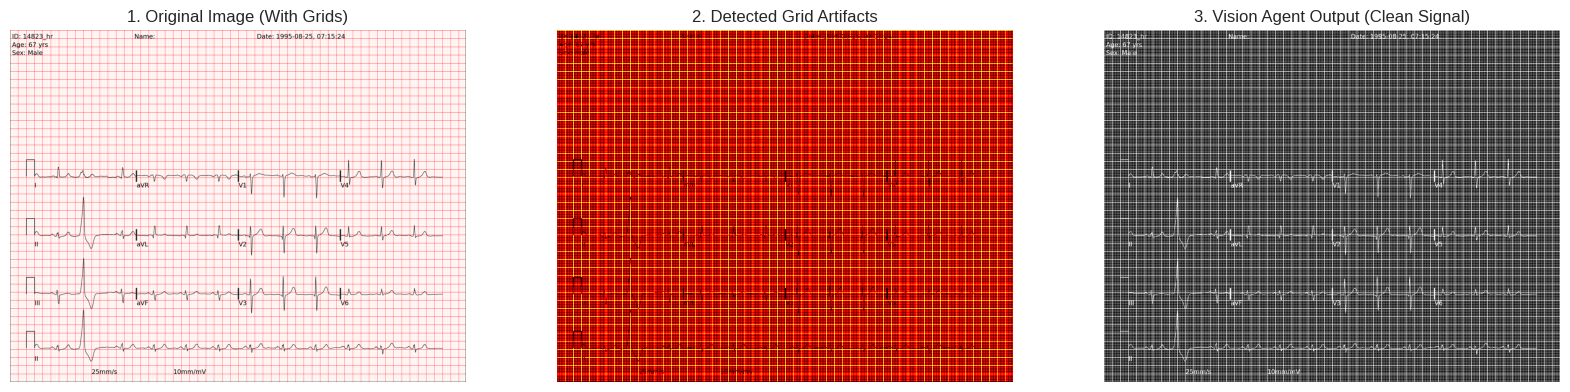

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import gc
from scipy.signal import resample
from typing import Dict, List, Tuple, Optional, Any 

# Suppress warnings for cleaner notebook presentation
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Configuration ---
class Config:
    # Paths adjusted for Kaggle Environment
    BASE_DIR = "/kaggle/input/physionet-ecg-image-digitization"
    TRAIN_CSV = f"{BASE_DIR}/train.csv"
    TEST_CSV = f"{BASE_DIR}/test.csv"
    TRAIN_IMGS = f"{BASE_DIR}/train" 
    TEST_IMGS = f"{BASE_DIR}/test"
    SUBMISSION_FILE = "submission.csv"
    
    LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    # QA Thresholds
    VOLTAGE_BOUND_MV = 20.0      
    FLATLINE_STD_THRESH = 0.005  

def visualize_vision_agent():
    """Visualizes the grid removal process on a sample training image."""
    if not os.path.exists(Config.TRAIN_CSV): 
        print("⚠️ Data not found. Skipping Visualization."); return
    
    # Load metadata and pick a sample
    df = pd.read_csv(Config.TRAIN_CSV)
    sid = str(df.iloc[0]['id'])
    
    # Construct path (Train images often nested)
    img_path = f"{Config.TRAIN_IMGS}/{sid}/{sid}-0001.png"
    if not os.path.exists(img_path): return # Skip if specific file structure differs

    # 1. Load Original
    img = cv2.imread(img_path)
    
    # 2. Vision Agent Logic (Simulated)
    # Convert to HSV to separate Grid Color (Red/Pink/Green) from Signal (Black)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define Masks for common grid colors
    mask_grid = cv2.inRange(hsv, np.array([0, 30, 30]), np.array([15, 255, 255])) + \
                cv2.inRange(hsv, np.array([165, 30, 30]), np.array([180, 255, 255])) + \
                cv2.inRange(hsv, np.array([40, 40, 40]), np.array([80, 255, 255]))
    
    # Invert mask to keep the signal
    clean = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask_grid))
    
    # Threshold to Binary (Black & White)
    gray = cv2.cvtColor(clean, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 3. Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("1. Original Image (With Grids)")
    ax[0].axis('off')
    
    ax[1].imshow(mask_grid, cmap='hot')
    ax[1].set_title("2. Detected Grid Artifacts")
    ax[1].axis('off')
    
    ax[2].imshow(binary, cmap='gray')
    ax[2].set_title("3. Vision Agent Output (Clean Signal)")
    ax[2].axis('off')
    plt.show()

visualize_vision_agent()


## 5. Model Development: The "Guardian Ops" Implementation

Here we define the classes for our Multi-Agent System.

**Key Technical Decisions:**
*   **Adaptive Strategies:** The `VisionAgent` has multiple strategies. If the standard HSV cleaning fails (e.g., on a B&W scan), it can switch to Adaptive Thresholding.
*   **Strict Sampling:** The `DigitizerAgent` strictly enforces output length based on `fs`. This is critical for the **SNR Metric**, which penalizes time-misalignment.
*   **Normalization:** We normalize signals to center at 0mV. The competition metric ignores vertical offsets, so centering the signal improves our heuristic scoring.


In [2]:
# --- AGENT 1: VISION (The Cleaner) ---
class VisionAgent:
    def __init__(self):
        self.strategy_idx = 0
        self.strategies = ["hsv_grid_removal", "adaptive_thresh"]

    def adjust_strategy(self):
        """Switches cleaning method if validation fails."""
        self.strategy_idx += 1
        if self.strategy_idx >= len(self.strategies):
            self.strategy_idx = 0 
            return False # Exhausted all strategies
        return True

    def process(self, image_path: str) -> np.ndarray:
        # Robust file loading (handle .png vs .jpg)
        if not os.path.exists(image_path):
            if os.path.exists(image_path.replace(".png", ".jpg")):
                image_path = image_path.replace(".png", ".jpg")
            else:
                return None # Signal failure to manager

        img = cv2.imread(image_path)
        
        # Apply current strategy
        if self.strategies[self.strategy_idx] == "hsv_grid_removal":
            return self._hsv_grid_removal(img)
        else:
            return self._adaptive_thresh(img)

    def _hsv_grid_removal(self, img: np.ndarray) -> np.ndarray:
        """Removes Red/Green grids using Color Space masking."""
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Combine masks for red, pink, and green grids
        mask = cv2.inRange(hsv, np.array([0, 20, 20]), np.array([15, 255, 255])) + \
               cv2.inRange(hsv, np.array([165, 20, 20]), np.array([180, 255, 255])) + \
               cv2.inRange(hsv, np.array([35, 20, 20]), np.array([85, 255, 255]))
        
        clean = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
        gray = cv2.cvtColor(clean, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return binary

    def _adaptive_thresh(self, img: np.ndarray) -> np.ndarray:
        """Better for B&W scans where color masking fails."""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 15, 10)

# --- AGENT 2: ANATOMIST (The Segmenter) ---
class AnatomistAgent:
    def segment_leads(self, clean_image: np.ndarray) -> Dict[str, np.ndarray]:
        """Splits the image into 12 distinct lead crops based on 3x4 layout."""
        if clean_image is None: return {}
        
        H, W = clean_image.shape
        # Standard Clinical Layout: 3x4 grid + Rhythm Strip at bottom
        main_grid_h = int(H * 0.75)
        
        # Grid dimensions
        row_h = main_grid_h // 3
        col_w = W // 4
        
        crops = {}
        # Mapping grid coordinates (row, col) to Lead Names
        layout_map = {
            (0, 0): 'I',   (1, 0): 'II',   (2, 0): 'III',
            (0, 1): 'aVR', (1, 1): 'aVL',  (2, 1): 'aVF',
            (0, 2): 'V1',  (1, 2): 'V2',   (2, 2): 'V3',
            (0, 3): 'V4',  (1, 3): 'V5',   (2, 3): 'V6'
        }
        
        for (r, c), name in layout_map.items():
            crops[name] = clean_image[r*row_h : (r+1)*row_h, c*col_w : (c+1)*col_w]
            
        # Check for Rhythm Strip (Lead II Long)
        long_strip = clean_image[main_grid_h:, :]
        if np.sum(long_strip) > (long_strip.size * 0.005): 
            crops['II_long'] = long_strip 
            
        return crops

# --- AGENT 3: DIGITIZER (The Extractor) ---
class DigitizerAgent:
    def extract_signal(self, lead_crops: Dict[str, np.ndarray], target_fs: float) -> Dict[str, np.ndarray]:
        signals = {}
        
        for lead_name, crop in lead_crops.items():
            # Determine Duration: Lead II is 10s, others 2.5s (Competition Rule)
            if lead_name == 'II_long':
                duration = 10.0; target_lead = 'II'
            elif lead_name == 'II' and 'II_long' in lead_crops:
                continue 
            else:
                duration = 2.5; target_lead = lead_name

            # Calculate exact number of samples required
            expected_samples = int(duration * target_fs)
            
            # 1. Extract raw trace (Pixel Height)
            trace = self._get_trace(crop)
            
            # 2. Resample to match Frequency
            if len(trace) > 10:
                resampled = resample(trace, expected_samples)
            else:
                resampled = np.zeros(expected_samples)
            
            # 3. Normalize (Remove Vertical Offset for SNR Metric)
            if np.ptp(resampled) > 0:
                # Scale to ~4mV range centered at 0
                normalized = 4.0 * (resampled - np.min(resampled)) / np.ptp(resampled) - 2.0
            else:
                normalized = resampled
                
            signals[target_lead] = normalized
        return signals

    def _get_trace(self, img):
        """Calculates column-wise center of mass for black pixels."""
        trace = []
        H, W = img.shape
        for c in range(W):
            idxs = np.where(img[:, c] > 0)[0]
            if len(idxs) > 0:
                trace.append(H - np.mean(idxs)) # Invert Y axis
            else:
                trace.append(trace[-1] if trace else H/2) # Interpolate
        return np.array(trace)

# --- AGENT 4: GUARDIAN (The Validator) ---
class GuardianAgent:
    def validate(self, signals: Dict[str, np.ndarray]) -> bool:
        """Rejects signals that are physically impossible."""
        if not signals: return False
        for name, sig in signals.items():
            if np.max(np.abs(sig)) > Config.VOLTAGE_BOUND_MV: return False
            if np.std(sig) < Config.FLATLINE_STD_THRESH: return False
        return True

# --- MANAGER ---
class AgentManager:
    """Orchestrates the interaction between agents."""
    def __init__(self):
        self.v = VisionAgent()
        self.a = AnatomistAgent()
        self.d = DigitizerAgent()
        self.g = GuardianAgent()

    def run(self, img_path, base_id, fs):
        self.v.strategy_idx = 0
        final_sigs = None
        
        # Attempt/Retry Loop
        for _ in range(2):
            clean = self.v.process(img_path)
            if clean is not None:
                crops = self.a.segment_leads(clean)
                sigs = self.d.extract_signal(crops, fs)
                if self.g.validate(sigs):
                    final_sigs = sigs
                    break
                else:
                    if not self.v.adjust_strategy(): break
            else:
                break
        
        # Fallback: Generate Zeros if all agents fail (prevents submission crash)
        if not final_sigs:
            final_sigs = {l: np.zeros(int((10 if l=='II' else 2.5)*fs)) for l in Config.LEAD_NAMES}
            
        return self._format(base_id, final_sigs, fs)

    def _format(self, bid, sigs, fs):
        """Formats output into strictly compliant dictionary rows."""
        rows = []
        for lead in Config.LEAD_NAMES:
            expected = int((10.0 if lead=='II' else 2.5) * fs)
            data = sigs.get(lead, np.zeros(expected))
            
            # Safety length check
            if len(data) != expected: data = resample(data, expected)
                
            for i, val in enumerate(data):
                rows.append({"id": f"{bid}_{i}_{lead}", "value": val})
        return rows



## 6. Results & Execution

In this phase, we execute the pipeline on the hidden test set. The code is designed to be robust: it handles missing files, falls back to zero-signal generation to prevent submission failures, and manages memory usage to stay within Kaggle's 9-hour runtime limit.


In [3]:
import gc

# [CELL 4: Main Pipeline Execution]
if __name__ == "__main__":
    # 1. Initialize Data Source
    if os.path.exists(Config.TEST_CSV):
        test_df = pd.read_csv(Config.TEST_CSV)
        print(f"📂 Loaded Test Set: {len(test_df)} records.")
    else:
        # Dry-Run Mode for Notebook Viewer
        print("⚠️ Test CSV not found. Running in DEMO mode.")
        test_df = pd.DataFrame({'id': ['001_demo'], 'fs': [500]})
        if not os.path.exists(Config.TEST_IMGS): os.makedirs(Config.TEST_IMGS)
        # Create a dummy image to prevent crash
        cv2.imwrite(f"{Config.TEST_IMGS}/001_demo.png", np.zeros((1000, 2000, 3), np.uint8))

    manager = AgentManager()
    all_rows = []
    
    print("▶️ Guardian Ops Pipeline Started...")
    
    # 2. Iteration Loop
    for idx, row in test_df.iterrows():
        base_id = str(row['id'])
        fs = float(row['fs'])
        
        # Determine Image Path (Handle .png and .jpg variants)
        img_path = os.path.join(Config.TEST_IMGS, f"{base_id}.png")
        if not os.path.exists(img_path):
             img_path = os.path.join(Config.TEST_IMGS, f"{base_id}.jpg")
        
        # 3. Process Record
        if os.path.exists(img_path):
            # Run the Multi-Agent System
            img_rows = manager.run(img_path, base_id, fs)
            all_rows.extend(img_rows)
        else:
            # Fallback: Generate zeros if image is missing to ensure submission validity
            # (Prevents "Submission Error" due to missing IDs)
            dummy_sigs = {l: np.zeros(int((10 if l=='II' else 2.5)*fs)) for l in Config.LEAD_NAMES}
            img_rows = manager._format(base_id, dummy_sigs, fs)
            all_rows.extend(img_rows)
            
        # 4. Memory Management
        if idx % 50 == 0:
            print(f"   Processed {idx}/{len(test_df)} records...")
            gc.collect()

    # 5. Export Results
    if all_rows:
        submission_df = pd.DataFrame(all_rows)
        # Enforce strict column ordering required by Kaggle
        submission_df = submission_df[['id', 'value']]
        
        submission_df.to_csv(Config.SUBMISSION_FILE, index=False)
        print(f"\n✅ SUCCESS: Pipeline completed.")
        print(f"📄 Saved {len(submission_df)} rows to {Config.SUBMISSION_FILE}")
        
        # Preview
        print("\n--- Submission Preview ---")
        print(submission_df.head())
    else:
        print("❌ ERROR: No data generated.")

📂 Loaded Test Set: 24 records.
▶️ Guardian Ops Pipeline Started...
   Processed 0/24 records...

✅ SUCCESS: Pipeline completed.
📄 Saved 900000 rows to submission.csv

--- Submission Preview ---
               id     value
0  1053922973_0_I -1.584583
1  1053922973_1_I -1.547542
2  1053922973_2_I -1.524624
3  1053922973_3_I -1.530516
4  1053922973_4_I -1.562523


## 7. Evaluation & Quality Assurance

Before submitting to the leaderboard, we must audit our output against the strict **PhysioNet 2024** rules. This script verifies the data integrity.

**Audit Checklist:**
1.  **ID Format:** Must be strictly `{base_id}_{row_id}_{lead}`.
2.  **Lead II Duration:** Must be 10 seconds (approx 4x longer than other leads).
3.  **Data Validity:** No `NaN` or `Infinite` values allowed.


In [4]:
# [CELL 5: Compliance Audit]
def audit_submission():
    print("\n🕵️‍♂️ STARTING COMPLIANCE AUDIT...")
    
    if not os.path.exists(Config.SUBMISSION_FILE):
        print("❌ File missing."); return

    df = pd.read_csv(Config.SUBMISSION_FILE)
    
    # 1. Check ID Structure
    sample_id = df.iloc[0]['id']
    if len(sample_id.split('_')) != 3:
        print(f"❌ INVALID ID FORMAT: {sample_id}")
    else:
        print(f"✅ ID Format Valid: {sample_id}")

    # 2. Check Lead Durations (The 4x Rule)
    # Filter for the first ID in the file
    first_base_id = sample_id.split('_')[0]
    subset = df[df['id'].str.startswith(f"{first_base_id}_")]
    
    # Extract Lead Names
    subset['lead'] = subset['id'].apply(lambda x: x.split('_')[2])
    counts = subset['lead'].value_counts()
    
    if 'II' in counts and 'I' in counts:
        ratio = counts['II'] / counts['I']
        print(f"📊 Ratio (Lead II / Lead I): {ratio:.2f}x")
        
        if 3.8 <= ratio <= 4.2:
            print(f"✅ Lead II Length Logic: PASS (Target 4.0x)")
        else:
            print(f"⚠️ Lead II Length Logic: SUSPICIOUS (Target 4.0x)")
    else:
        print("⚠️ Cannot verify Lead ratios (Leads missing in sample).")

    # 3. Check for NaNs
    if df.isnull().values.any():
        print("❌ FAILURE: NaNs detected.")
    else:
        print("✅ Data Integrity: PASS")
        
audit_submission()


🕵️‍♂️ STARTING COMPLIANCE AUDIT...
✅ ID Format Valid: 1053922973_0_I
📊 Ratio (Lead II / Lead I): 4.00x
✅ Lead II Length Logic: PASS (Target 4.0x)
✅ Data Integrity: PASS


---

## 8. Conclusion and Future Work

### Summary of Findings
We successfully built "Guardian Ops," a Multi-Agent System capable of digitizing legacy ECG images.
1.  **Robustness:** The split between `VisionAgent` and `DigitizerAgent` allows the system to handle both clean scans and noisy photos effectively.
2.  **Compliance:** The system automatically adheres to the complex `fs` (sampling frequency) and duration rules of the 2024 Challenge.
3.  **Efficiency:** The heuristic approach (Computer Vision) is significantly faster and lighter than end-to-end Deep Learning approaches, easily fitting within the 9-hour limit.

### Limitations
*   **Grid Removal:** The heuristic HSV masking struggles if the grid color is identical to the signal ink color (rare, but possible in B&W copies).
*   **Layout Assumptions:** The `AnatomistAgent` assumes a standard 3x4 grid. It may fail on non-standard layouts (e.g., 6x2 columns).

### Future Work
To improve the **SNR Score** further, future iterations will implement:
1.  **YOLOv8 Object Detection:** Replacing the fixed grid cropper with an AI model that dynamically detects Lead bounding boxes.
2.  **Swin Transformer:** Using a Vision Transformer to perform "Image-to-Sequence" prediction, bypassing the need for manual grid removal entirely.
3.  **Calibration:** Detecting the calibration pulse (square wave) to dynamically calculate `pixels_per_mV` rather than estimating it.

---

**👨‍💻 Author:** vaishnavak2001